# K-Means Clustering

Let's look at the NBA dataset of basket ball player performance from the 2013-2014 season.

Here are some selected columns:

* player -- name of the player
* pos -- the position of the player
* g -- number of games the player was in
* pts -- total points the player scored
* fg. -- field goal percentage
* ft. -- free throw percentage

In [44]:
import pandas as pd
import numpy as np

nba = pd.read_csv("data/nba_2013.csv")
nba.head(3)

,player,pos,age,bref_team_id,g,gs,mp,fg,fga,fg.,...,drb,trb,ast,stl,blk,tov,pf,pts,season,season_end
0,Quincy Acy,SF,23,TOT,63,0,847,66,141,0.468,...,144,216,28,23,26,30,122,171,2013-2014,2013
1,Steven Adams,C,20,OKC,81,20,1197,93,185,0.503,...,190,332,43,40,57,71,203,265,2013-2014,2013
2,Jeff Adrien,PF,27,TOT,53,12,961,143,275,0.520,...,204,306,38,24,36,39,108,362,2013-2014,2013


Point guards ('PG' as pos) play one of the most crucial roles on a team because their primary responsibility is to create scoring opportunities for the team. We are going to focus our lesson on a machine learning technique called clustering, which allows us to visualize the types of point guards as well as group similar point guards together.

In [45]:
nba = nba[nba['pos']=='PG']

Let us calculate the number of points per game using each player's total points (pts) and the number of games (g) they played. 

In [46]:
nba['ppg'] = nba['pts'] / nba['g']

# Sanity check, make sure ppg = pts/g
nba[['pts', 'g', 'ppg']].head(5)

,pts,g,ppg
24,930,71,13.098592
29,150,20,7.500000
30,660,79,8.354430
38,666,72,9.250000
50,378,55,6.872727


Now let's create a column, atr, for the Assist Turnover Ratio, which is calculated by dividing total assists (ast) by total turnovers (tov):

In [47]:
nba = nba[nba['tov'] != 0]
nba['atr'] = nba['ast'] / nba['tov']

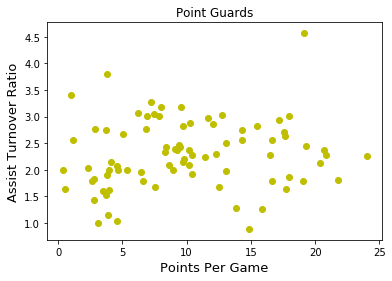

In [48]:
import matplotlib.pyplot as plt

plt.scatter(nba['ppg'], nba['atr'], c='y')
plt.title("Point Guards")
plt.xlabel('Points Per Game', fontsize=13)
plt.ylabel('Assist Turnover Ratio', fontsize=13)
plt.show()

K-Means Clustering is a popular centroid-based clustering algorithm that we will use. The K in K-Means refers to the number of clusters we want to segment our data into. The key part with K-Means (and most unsupervised machine learning techniques) is that we have to specify what k is. There are advantages and disadvantages to this, but one advantage is that we can pick the k that makes the most sense for our use case. We'll set k to 5 since we want K-Means to segment our data into 5 clusters.

Setup K-Means is an iterative algorithm that switches between recalculating the centroid of each cluster and the players that belong to that cluster. To start, select 5 players at random and assign their coordinates as the initial centroids of the just created clusters.

In [49]:
num_clusters = 5
# Use numpy's random function to generate a list, length: num_clusters, of indices
random_initial_points = np.random.choice(nba.index, size=num_clusters)
# Use the random indices to create the centroids
centroids = nba.loc[random_initial_points]

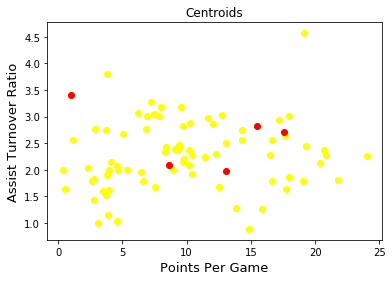

In [50]:
plt.scatter(nba['ppg'], nba['atr'], c='yellow')
plt.scatter(centroids['ppg'], centroids['atr'], c='red')
plt.title("Centroids")
plt.xlabel('Points Per Game', fontsize=13)
plt.ylabel('Assist Turnover Ratio', fontsize=13)
plt.show()

In [51]:
def centroids_to_dict(centroids):
    dictionary = dict()
    # iterating counter we use to generate a cluster_id
    counter = 0

    # iterate a pandas data frame row-wise using .iterrows()
    for index, row in centroids.iterrows():
        coordinates = [row['ppg'], row['atr']]
        dictionary[counter] = coordinates
        counter += 1

    return dictionary

centroids_dict = centroids_to_dict(centroids)

Let's create the function calculate_distance, which takes in 2 lists (the player's values for ppg and atr and the centroid's values for ppg and atr) and returns the euclidean distance between the 2 points.

In [52]:
import math

def calculate_distance(centroid, player_values):
    root_distance = 0
    
    for x in range(0, len(centroid)):
        difference = centroid[x] - player_values[x]
        squared_difference = difference**2
        root_distance += squared_difference

    euclid_distance = math.sqrt(root_distance)
    return euclid_distance

q = [5, 2]
p = [3,1]

# Sqrt(5) = ~2.24
print(calculate_distance(q, p))

2.23606797749979


In [53]:
def assign_to_cluster(centroids_dict, player_values):
    mini =  float("inf")
    key_min = 0

    for key, centroid in centroids_dict.items():
        distance = calculate_distance(centroid, player_values)
        if distance < mini:
                mini = distance
                key_min = key
    return key_min

nba['cluster'] = nba.apply(lambda row: assign_to_cluster(centroids_dict, (row['ppg'],row['atr'])), axis=1)

In [54]:
nba.head(3)

,player,pos,age,bref_team_id,g,gs,mp,fg,fga,fg.,...,stl,blk,tov,pf,pts,season,season_end,ppg,atr,cluster
24,D.J. Augustin,PG,26,TOT,71,9,1939,298,718,0.415,...,53,3,125,147,930,2013-2014,2013,13.098592,2.504000,4
29,Leandro Barbosa,PG,31,PHO,20,0,368,56,131,0.427,...,7,4,19,30,150,2013-2014,2013,7.500000,1.684211,1
30,Jose Barea,PG,29,MIN,79,1,1471,254,656,0.387,...,26,0,125,129,660,2013-2014,2013,8.354430,2.424000,1


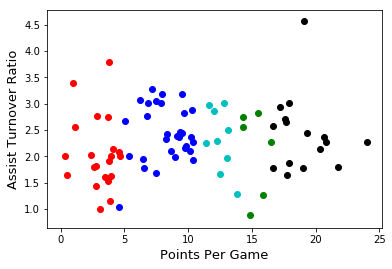

In [55]:
def visualize_clusters(df, num_clusters):
    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']

    for n in range(num_clusters):
        clustered_df = df[df['cluster'] == n]
        plt.scatter(clustered_df['ppg'], clustered_df['atr'], c=colors[n-1])
        plt.xlabel('Points Per Game', fontsize=13)
        plt.ylabel('Assist Turnover Ratio', fontsize=13)
    plt.show()

visualize_clusters(nba, 5)

In [56]:
def recalculate_centroids(df):
    new_centroids_dict = dict()
    
    for cluster_id in range(num_clusters):
        values_in_cluster = df[df['cluster'] == cluster_id]
        # Calculate new centroid using mean of values in the cluster.
        new_centroid = [np.average(values_in_cluster['ppg']), np.average(values_in_cluster['atr'])]
        new_centroids_dict[cluster_id] = new_centroid
    return new_centroids_dict

centroids_dict = recalculate_centroids(nba)

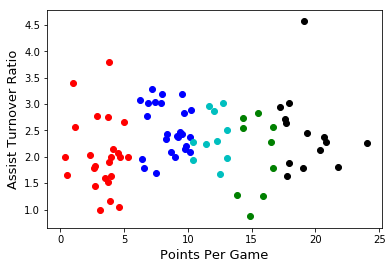

In [58]:
nba['cluster'] = nba.apply(lambda row: assign_to_cluster(centroids_dict, (row['ppg'],row['atr'])), axis=1)
visualize_clusters(nba, num_clusters)

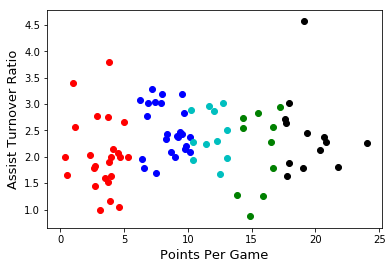

In [60]:
centroids_dict = recalculate_centroids(nba)
nba['cluster'] = nba.apply(lambda row: assign_to_cluster(centroids_dict, (row['ppg'],row['atr'])), axis=1)
visualize_clusters(nba, num_clusters)

Our exploration helped us get a sense of the 5 types of point guards as based on each player's Assist Turnover Ratio and Points Per Game.

# Using sklearn

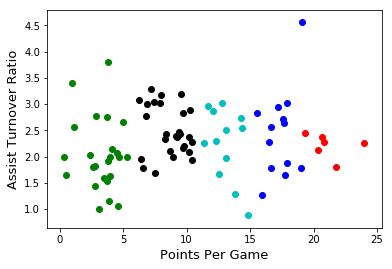

In [61]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=num_clusters)
kmeans.fit(nba[['ppg', 'atr']])
nba['cluster'] = kmeans.labels_

visualize_clusters(nba, num_clusters)